In [ ]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sklearn.metrics

## MNIST data loading and processing

Downloading the data

In [ ]:
# Load the MNIST dataset distributed with Keras.
(x_train0, y_train), (x_test0, y_test)= tf.keras.datasets.mnist.load_data(path='mnist.npz')

11493376/11490434 [==============================] - 0s 0us/step


Preprocessing

Number of original training examples: 60000
Number of original test examples: 10000
5


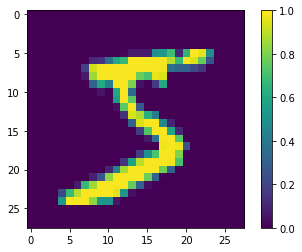

In [ ]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train0/255.0, x_test0/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

# Show the first example:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [ ]:
# Flattening the data:
n_features= x_train.shape[1]*x_train.shape[2]
x_train = x_train.reshape(-1, n_features)
x_test = x_test.reshape(-1, n_features)
x_train.shape

(60000, 784)

# MLP

In [ ]:
class Cross_Entropy:
    def __init__(self, activation_fn):
        """
        :param activation_fn: Class object of the activation function.
        """
        self.activation_fn = activation_fn

    def activation(self, z):
      return self.activation_fn.activation(z)

    def loss(y_true, y_pred):
        """
        Computes cross entropy between targets (encoded as one-hot vectors)
        and predictions. 
        Input: predictions (N, k) ndarray
              targets (N, k) ndarray        
        Returns: scalar
        """
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
        return loss

    @staticmethod
    def prime(Y, AL):  
        return AL - Y

    def delta(self, y_true, y_pred):
      
        return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)

In [ ]:
class MSE:
    def __init__(self, activation_fn):
        """
        :param activation_fn: Class object of the activation function.
        """
        self.activation_fn = activation_fn

    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        """
        :param y_true: (array) One hot encoded truth vector.
        :param y_pred: (array) Prediction vector
        :return: (flt)
        """
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def prime(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        """
        Back propagation error delta
        :return: (array)
        """
        return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)

### MLP


In [ ]:
import numpy as np
class Relu:
    def activation(z):
      return np.maximum(0,z)
    def prime(z):
        z[z<=0] = 0
        z[z>0] = 1
        return z

class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    def prime(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))

class tanh:
    @staticmethod
    def activation(z):
	    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    def prime(z):
      return 1 - np.power(tanh.activation(z), 2)

class softmax:
    @staticmethod
    def activation(x):
      e = np.exp(x-np.max(x))
      s = np.sum(e, axis=1, keepdims=True)
      return e/s
    @staticmethod
    def prime(z):
        return softmax.activation(z)*softmax.activation(1-z)

In [ ]:
class MLP:
    def __init__(self, dimensions, activations):
        """
        dimensions as list:  Dimensions of the neural net. (input, hidden layer(s), output)
        activations as list :  Activations functions.

        """
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        # Weights and biases are initiated by index. For a one hidden layer net you will have a w[1] and w[2]
        self.w = {}
        self.b = {}
        self.lambd = None
        # Activations are also initiated by index. For the example we will have activations[2] and activations[3]
        self.activations = {}
        # initialize the neural net
        for i in range(len(dimensions) - 1):
            self.w[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.b[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activations[i]

    def _feed_forward(self, x):
        """
        Execute a forward feed through the network.

        x: (array) Batch of input data vectors.
        :return:  Node outputs and activations per layer. 
                 The numbering of the output is equivalent to the layer numbers.
        """
        # w(x) + b
        z = {}
        # activations: f(z)
        a = {1: x}  # First layer has no activations as input. The input x is the input.

        for i in range(1, self.n_layers):
            # current layer = i
            # activation layer = i + 1
            z[i + 1] = np.dot(a[i], self.w[i]) + self.b[i]
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])

        return z, a  


    def _update_w_b(self, index, dw, delta):
        """
        Method to update weights and biases.
        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """
        dw += (self.lambd) * self.w[index] 
        self.w[index] -= self.learning_rate * dw
        self.b[index] -= self.learning_rate * np.mean(delta, 0)

    def _back_prop(self, z, a, y_true):

        # Determine partial derivative and delta for the output layer.
        # delta output layer
        delta = self.loss.delta(y_true, a[self.n_layers])
        dw = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (dw, delta)
        }

        # In case of three layer net will iterate over i = 2 and i = 1
        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(z[i])
            dw = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (dw, delta)
	
        # Update the weights and biases
        for k, v in update_params.items():
            self._update_w_b(k, v[0], v[1])
    
    # Set plot to True to plot the test and train accuracy against number of epoches
    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size, loss,lambd, learning_rate=1e-3, plot= False):
        # assert that shape is same
        y_train = np.eye(10)[y_train]
        y_test = np.eye(10)[y_test]
        if not X_train.shape[0] == y_train.shape[0]:
            raise ValueError("Length of X_train and y arrays don't match")
        # Initiate the loss object with the final activation function
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        self.lambd = lambd
        train_log = []
        test_log = []
        los=[]
        for i in range(epochs):
            # Shuffle the data
            seed = np.arange(X_train.shape[0])
            np.random.shuffle(seed)
            x_ = X_train[seed]
            y_ = y_train[seed]
            # loop over minibatches
            for j in range(X_train.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self._feed_forward(x_[k:l])
                self._back_prop(z, a, y_[k:l])

            train_log.append(np.mean(self.predict(X_train) == np.argmax(y_train,axis = 1)))
            test_log.append(np.mean(self.predict(X_test) == np.argmax(y_test,axis = 1)))

            if (i + 1) % 10 == 0:
               _, a = self._feed_forward(X_train)
               y_pred = a[self.n_layers]
               los.append(loss.loss(y_train, y_pred)) 
            
            if plot:
               clear_output()
               print("Epoch", i)
               print("Train accuracy:", train_log[-1])
               print("Test accuracy:", test_log[-1])
               plt.plot(train_log, label = 'train accuracy')
               plt.plot(test_log, label='test accuracy')
               plt.legend(loc = 'best')
               plt.ylabel('Accuracy')
               plt.xlabel('epoches')
               plt.grid()
               plt.show()

        if plot:
           plt.figure()    
           plt.plot((np.arange(len(los))+1)*10, los)
           plt.ylabel('Loss')
           plt.xlabel('epoches')
           plt.grid()
           plt.show()
        return train_log , test_log

    def predict(self, x):
        """
        :param x: (array) Containing parameters
        :return: (array) A 2D array of shape (n_cases, n_classes) from output layer.
        """
        _, a = self._feed_forward(x)
        # return a[self.n_layers]
        return np.argmax(a[self.n_layers],axis=1)

def evaluate_acc (True_label,Predicted_label):
    return np.sum(True_label == Predicted_label)/Predicted_label.shape[0]


# K_fold cross validation

In [ ]:
def cross_validation_split(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def kfoldCV(x , y, n_folds , model, lr, lambdaa, n_epoches):
    score_val = np.zeros(n_folds)
    for f, (tr, val) in enumerate(cross_validation_split(x.shape[0], n_folds)):
        # train_log, val_log = model.evaluate_acc(x[tr], y[tr], x[val], y[val], epochs=200, batch_size=128, loss=Cross_Entropy,lambd = 0, learning_rate=0.5e-3)
        train_log, val_log = model.fit(x[tr], y[tr], x[val], y[val], epochs=n_epoches, batch_size=256, loss=Cross_Entropy,lambd = lambdaa, learning_rate=lr)
        score_val[f] = evaluate_acc(y[val], model.predict(x[val]))
    return score_val, score_val.mean()

# method to get accuracy
def evaluate_acc (Predicted_label, True_label):
    return np.sum(True_label == Predicted_label)/True_label.shape[0]

# Experiment 1: Using different depths


Using 10000 of train dataset as validation set and leaving the test set untouch. 

In [ ]:
X_train, X_val = x_train[:-10000], x_train[-10000:]      
Y_train, Y_val = y_train[:-10000], y_train[-10000:]

## MLP with no hidden layers

Epoch 99
Train accuracy: 0.89072
Test accuracy: 0.9031


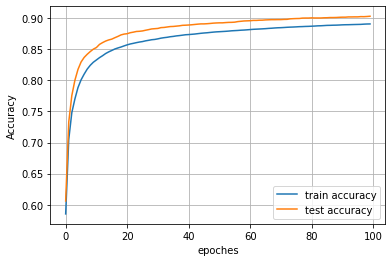

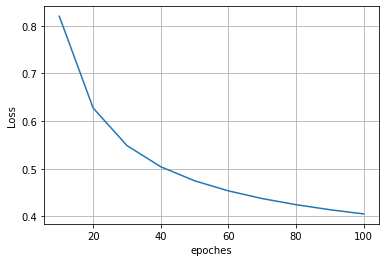

In [ ]:
# Initial training
nn = MLP((784, 10), (softmax,))
train_log, val_log = nn.fit(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=1e-3, plot=True)


Monitoring training accuracy against the number of iterations shows that training accuracy starts to stay constant after epoche 60. So, we set epochs =60 and then tune learning rate.


Hyperparameter tuning using 5-fold cross validation

for learning_rate= 0.01  => score = 0.9184833333333333, best score = 0.9184833333333333
for learning_rate= 0.1  => score = 0.925, best score = 0.925
for learning_rate= 0.5  => score = 0.9207333333333333, best score = 0.925
Best learning_rate: 0.1


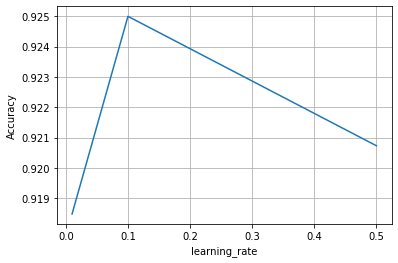

In [ ]:
#create a list of alpha values to tune on
learing_rate = np.array([ 1e-2, 1e-1, 5e-1])
best_score = 0
n=0
Acc=np.zeros(3)
# loop over the hyperparameters
for i in learing_rate:
      mn = MLP((784, 10), (softmax,))
      score = kfoldCV(x_train,y_train,5, mn, i, 0, 60)[1]
      Acc[n]= score
      n+=1
      if score > best_score:
         best_score = score
         best_lr = i
      print(f'for learning_rate= {i}  => score = {score}, best score = {best_score}')
print(f'Best learning_rate: {best_lr}')
plt.plot(learing_rate, Acc)
plt.ylabel('Accuracy')
plt.xlabel('learning_rate')
plt.grid()
plt.show()


Testing on test dataset using the best learning rate

Epoch 59
Train accuracy: 0.93
Test accuracy: 0.9254


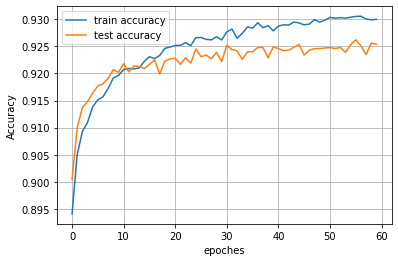

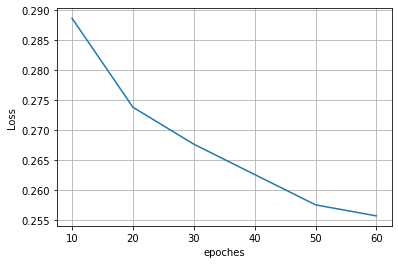

Accuracy on test data 0.9254

               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1005
           1       0.98      0.97      0.97      1154
           2       0.89      0.94      0.92       985
           3       0.91      0.90      0.91      1017
           4       0.92      0.94      0.93       956
           5       0.86      0.90      0.88       851
           6       0.96      0.93      0.94       979
           7       0.92      0.94      0.93      1007
           8       0.89      0.87      0.88       998
           9       0.92      0.89      0.91      1048

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
nn = MLP((784, 10), (softmax,))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, epochs=60, batch_size=256, loss=Cross_Entropy, lambd = 0, learning_rate=0.1, plot=True)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))
print("\n",sklearn.metrics.classification_report(nn.predict(x_test),y_test))


### MLP with 1 hidden layer 128 units ReLU

Epoch 99
Train accuracy: 0.9158
Test accuracy: 0.9241


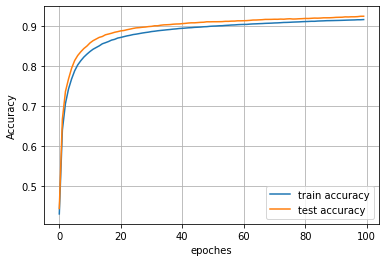

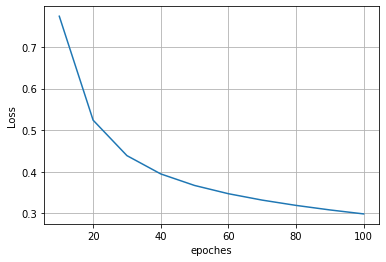

In [ ]:
# Initial training
nn = MLP((784, 128, 10), (Relu, softmax))
train_log, val_log = nn.fit(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=1e-3, plot=True)


Hyperparameter tuning

for learning_rate= 0.01  => score = 0.97625, best score = 0.97625
for learning_rate= 0.1  => score = 0.9936166666666667, best score = 0.9936166666666667
for learning_rate= 0.5  => score = 0.9925333333333335, best score = 0.9936166666666667
Best learning_rate: 0.1


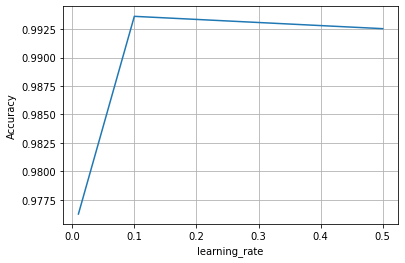

In [ ]:
learing_rate = np.array([1e-2, 1e-1, 5e-1])
best_score = 0
n=0
Acc=np.zeros(3)
# loop over the hyperparameters
for i in learing_rate:
      mn = MLP((784, 128, 10), (Relu, softmax))
      score = kfoldCV(x_train,y_train,5, mn, i, 0, 60)[1]
      Acc[n]= score
      n+=1
      if score > best_score:
         best_score = score
         best_lr = i
      print(f'for learning_rate= {i}  => score = {score}, best score = {best_score}')
print(f'Best learning_rate: {best_lr}')
plt.plot(learing_rate, Acc)
plt.ylabel('Accuracy')
plt.xlabel('learning_rate')
plt.grid()
plt.show()

testing on test dataset using the best learning rate

Epoch 59
Train accuracy: 0.9993166666666666
Test accuracy: 0.9779


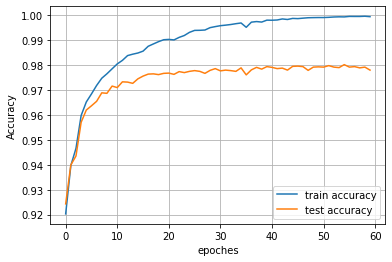

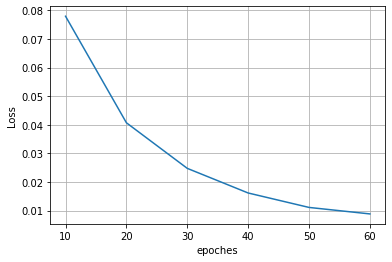

Accuracy on test data 0.9779

               precision    recall  f1-score   support

           0       0.99      0.98      0.98       991
           1       0.99      0.99      0.99      1137
           2       0.97      0.98      0.98      1019
           3       0.98      0.97      0.97      1029
           4       0.98      0.98      0.98       985
           5       0.97      0.98      0.97       890
           6       0.98      0.98      0.98       952
           7       0.98      0.98      0.98      1023
           8       0.96      0.98      0.97       954
           9       0.98      0.97      0.97      1020

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
nn = MLP((784, 128, 10), (Relu, softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, epochs=60, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))
print("\n",sklearn.metrics.classification_report(nn.predict(x_test),y_test))


### MLP with 2 hidden layers 128 units ReLU

Epoch 79
Train accuracy: 0.98784
Test accuracy: 0.9748


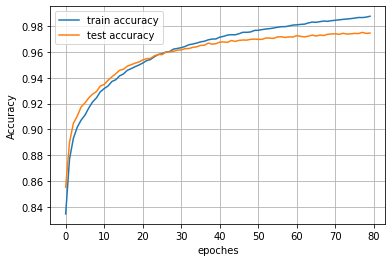

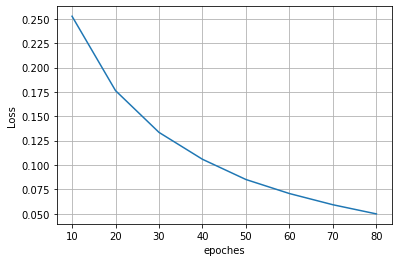

In [ ]:
nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, val_log = nn.fit(X_train, Y_train, X_val, Y_val, epochs=80, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=1e-2, plot=True)


Hyperparameter tuning

for learning_rate= 0.01  => score = 0.9853, best score = 0.9853
for learning_rate= 0.1  => score = 0.9941166666666668, best score = 0.9941166666666668
for learning_rate= 0.5  => score = 0.20791666666666667, best score = 0.9941166666666668
Best learning_rate: 0.1


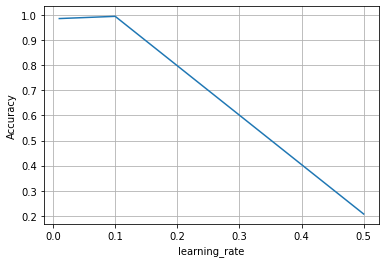

In [ ]:
#create a list of alpha values to tune on
learing_rate = np.array([1e-2, 1e-1, 5e-1])
best_score = 0
n=0
Acc=np.zeros(3)
# loop over the alphas
for i in learing_rate:
      mn = MLP((784, 128, 128, 10), [Relu,Relu,softmax])
      score = kfoldCV(x_train,y_train,5, mn,i,0, 60)[1]
      Acc[n]= score
      n+=1
      if score > best_score:
         best_score = score
         best_lr = i
      print(f'for learning_rate= {i}  => score = {score}, best score = {best_score}')
print(f'Best learning_rate: {best_lr}')
plt.plot(learing_rate, Acc)
plt.ylabel('Accuracy')
plt.xlabel('learning_rate')
plt.grid()
plt.show()

Testing on test dataset using the best learning rate

Epoch 39
Train accuracy: 1.0
Test accuracy: 0.9801


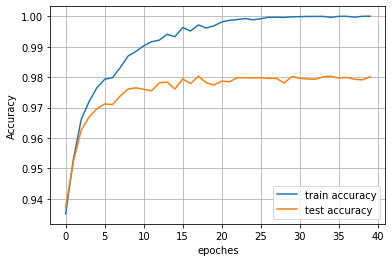

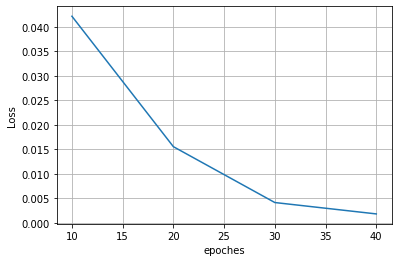

Accuracy on test data 0.9801


In [ ]:
nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, test_log = nn.fit(x_train, y_train, x_test, y_test, epochs=40, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))


# Experiment 2: Using different activation functions

### MLP with 2 hidden layers 128 units with sigmoid activations

In [ ]:
nn = MLP((784, 128, 128, 10), (Sigmoid, Sigmoid, softmax))
train_log, test_log = nn.fit(x_train, y_train, x_test, y_test, epochs=60, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))


Accuracy on test data 0.9734


### MLP with 2 hidden layers 128 units with tanh activations

In [ ]:
nn = MLP((784, 128, 128, 10), (tanh, tanh, softmax))
train_log, test_log = nn.fit(x_train, y_train, x_test, y_test, epochs=60, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))


Accuracy on test data 0.9799


# Experiment 3: Applying regularization

### 2 hidden layers each having 128 units with ReLU activations and L2 regularization

Lambda = 0.3

Epoch 39
Train accuracy: 0.7202
Test accuracy: 0.7312


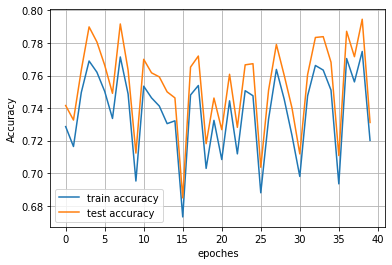

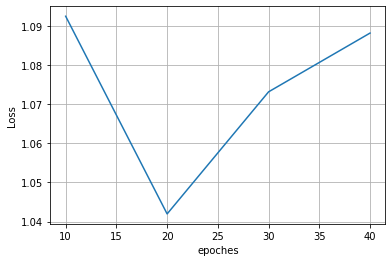

In [ ]:
nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, test_log = nn.fit(X_train, Y_train, X_val, Y_val, epochs=40, batch_size=256, loss=Cross_Entropy,lambd = 0.3, learning_rate=0.1, plot=True)


Lambda = 0.01

Epoch 39
Train accuracy: 0.97504
Test accuracy: 0.971


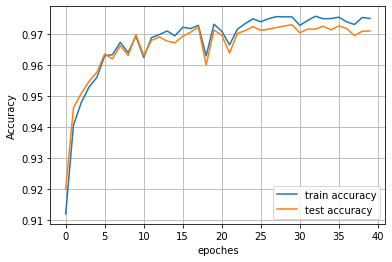

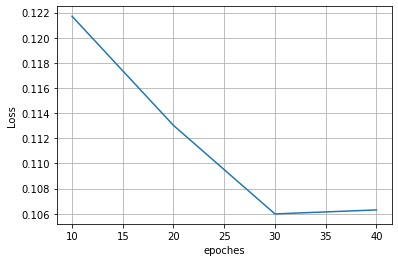

In [ ]:
nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, test_log = nn.fit(X_train, Y_train, X_val, Y_val, epochs=40, batch_size=256, loss=Cross_Entropy,lambd = 0.01, learning_rate=0.1, plot=True)


### Hyperparameter tuning

for learning_rate= 0.01 & Lambda = 0.3 => score = 0.7929499999999999, best score = 0.7929499999999999
for learning_rate= 0.01 & Lambda = 0.1 => score = 0.8853166666666666, best score = 0.8853166666666666
for learning_rate= 0.01 & Lambda = 0.01 => score = 0.9622999999999999, best score = 0.9622999999999999
for learning_rate= 0.1 & Lambda = 0.3 => score = 0.7509333333333335, best score = 0.9622999999999999
for learning_rate= 0.1 & Lambda = 0.1 => score = 0.8377666666666667, best score = 0.9622999999999999
for learning_rate= 0.1 & Lambda = 0.01 => score = 0.9670000000000002, best score = 0.9670000000000002
Best learning_rate: 0.1
Best lambda: 0.01


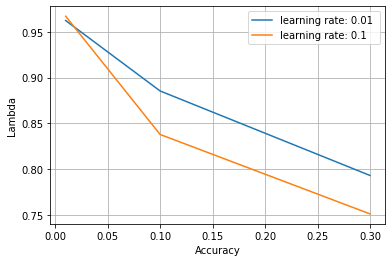

In [ ]:
#create a list of alpha values to tune on
learing_rate = np.array([1e-2, 1e-1])
lambdaa = np.array([0.3, 0.1, 0.01])
best_score = 0
Acc = np.zeros((3,3))
m = 0
# loop over the alphas
for i in learing_rate:
  n=0
  for j in lambdaa:
      mn = MLP((784, 128, 128, 10), [Relu,Relu,softmax])
      score = kfoldCV(x_train,y_train,5, mn,i,j,40)[1]
      Acc[m,n]=score
      n+=1
      if score > best_score:
         best_score = score
         best_lr = i
         best_lambda = j
      print(f'for learning_rate= {i} & Lambda = {j} => score = {score}, best score = {best_score}')
  plt.plot(lambdaa, Acc[m,:], label = "learning rate: {} ".format(i))
  m+=1
print(f'Best learning_rate: {best_lr}')
print(f'Best lambda: {best_lambda}')

plt.legend(loc = 'best')
plt.ylabel('Accuracy')
plt.xlabel('Lambda')
plt.grid()
plt.show()


### Testing on test dataset using the best hyperparameters

Epoch 49
Train accuracy: 0.9732666666666666
Test accuracy: 0.9705


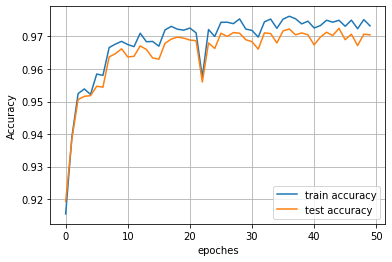

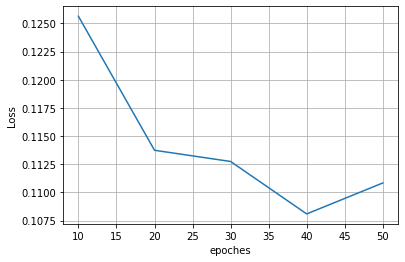

Accuracy on test data 0.9705

               precision    recall  f1-score   support

           0       0.98      0.97      0.98       990
           1       0.99      0.98      0.98      1153
           2       0.97      0.96      0.97      1039
           3       0.97      0.97      0.97      1006
           4       0.97      0.98      0.98       969
           5       0.97      0.98      0.97       888
           6       0.98      0.95      0.97       990
           7       0.97      0.95      0.96      1043
           8       0.94      0.99      0.96       929
           9       0.96      0.97      0.96       993

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
# use the above parameters
model = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, val_log = model.fit(x_train, y_train, x_test, y_test, epochs=50, batch_size=256, loss=Cross_Entropy,lambd = 0.01, learning_rate= 0.1, plot=True)
print("Accuracy on test data", evaluate_acc(model.predict(x_test),y_test))
print("\n",sklearn.metrics.classification_report(model.predict(x_test),y_test))


# Experiment 4: training on unnormalized images

In [ ]:
n_features= x_train0.shape[1]*x_train0.shape[2]
x_train_unnorm = x_train0.reshape(-1, n_features)
x_test_unnorm = x_test0.reshape(-1, n_features)

Epoch 19
Train accuracy: 0.09871666666666666
Test accuracy: 0.098


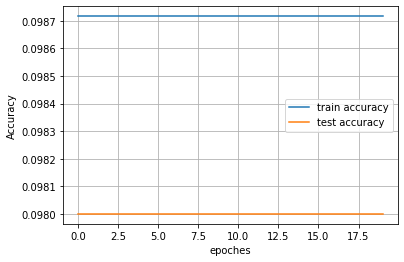

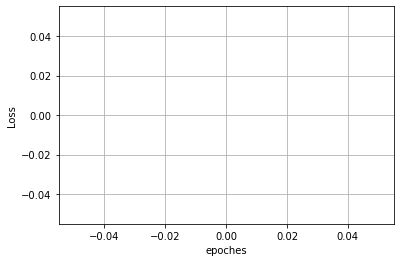

Accuracy on test data 0.1146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
model = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, val_log = model.fit(x_train_unnorm, y_train, x_test_unnorm, y_test, epochs=20, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
print("Accuracy on test data", evaluate_acc(nn.predict(x_test_unnorm),y_test))